In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from human2mouse_simple import *
from matplotlib.pyplot import rc_context

In [3]:
sc.settings.set_figure_params(dpi=80,dpi_save=600,facecolor='white',format='png')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.9.1 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [27]:
human_features = {
    'Immune': ['PTPRC','MS4A1', 'CD79A', 'CD3E', 'CD3D', 'CD247', 'ITGAX', 'CD14', 'CD68', 'C1QA', 'IGHG1', 'JCHAIN', 'CD2', 'KLRD1', 'TOX', 'IL7R', 'FOXP3'],
    'Fibroblast':['ACTA2', 'LAMB1', 'COL1A1', 'FN1'],
    'Endothelial': ['PECAM1', 'VWF', 'KDR', 'VEGFR2', 'VEGFA','FLT1'],
    'Epithelial': ['EPCAM', 'AR', 'KRT13', 'KRT17', 'CDH1', 'CD24', 'CD26']
}
mouse_features_d = {}
for key in human_features.keys():
    mouse_features_d[key] = [x.lower() for x in human_features[key]]
    mouse_features_d[key] = [x.capitalize() for x in mouse_features_d[key]]

mouse_features_d['Luminal'] = ['Cd24a', 'Krt8', 'Krt18']
mouse_features_d['Basal'] = ['Trp63', 'Krt5', 'Krt14']
mouse_features_d['Immune'] = ['Ptprc']
mouse_features_d['Tcell'] = ['Cd3e', 'Cd3e', 'Cd247','Il7r']
mouse_features_d['Myeloid'] = ['Itgax','C1qa','Cd14']
mouse_features_d['Bcell'] = ['Jchain','Ms4a1','Cd79a']

In [29]:
adata = sc.read_h5ad('scvi_adata.h5ad')
adata.obs_names = adata.obs['barcode_full']

adata_complete = sc.read_h5ad('adata_merged_complete_genes.h5ad')
adata_complete = adata_complete[adata_complete.obs['sample_name'].isin(['76-2f','79-1d','79-1e','79-2e'])].copy()

adata_complete.obs['is_doublet'] = [1 if x=='True' else 0 for x in adata_complete.obs['is_doublet']]
keep = [not x for x in adata_complete.obs['is_doublet']]
adata_complete = adata_complete[keep].copy()

adata_complete.obs_names = adata_complete.obs['barcode_full']
adata_complete.obs['leiden_scvi'] = adata.obs['leiden_scvi']
adata_complete.obsm['X_umap'] = adata.obsm['X_umap']

In [30]:
adata.var_names = adata.var.gene_name
adata_complete.var_names = adata_complete.var.gene_name

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.obs['log_cts']=np.log1p(adata.obs['total_counts'])
adata.obs['log_genes']=np.log1p(adata.obs['n_genes_by_counts'])

adata_complete.var['mt'] = adata_complete.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_complete, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata_complete.obs['log_cts']=np.log1p(adata_complete.obs['total_counts'])
adata_complete.obs['log_genes']=np.log1p(adata_complete.obs['n_genes_by_counts'])

In [32]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

sc.pp.normalize_total(adata_complete, target_sum=1e4)
sc.pp.log1p(adata_complete)
adata_complete.raw = adata_complete

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


In [33]:
n_clusters = len(np.unique(adata.obs['leiden_scvi']))
palette = sns.color_palette("tab20")+sns.color_palette("Set2",n_clusters-20)

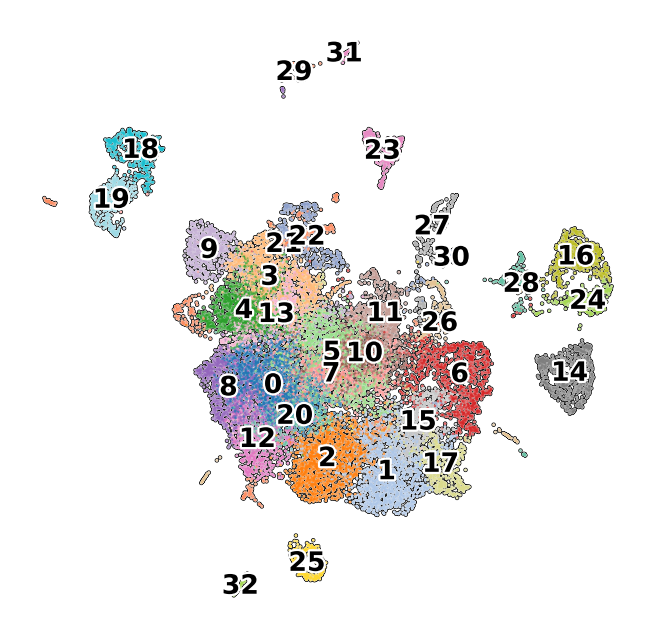

In [34]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color='leiden_scvi', add_outline=True, legend_loc='on data',title='',
               legend_fontsize=12, legend_fontoutline=2,frameon=False, palette=palette)

In [35]:
rename_sample_name = {
    '79-1d': 'Vehicle2',
    '79-2e': 'Vehicle1',
    '76-2b': 'EPZ1',
    '79-2f': 'EPZ2',
    '79-1e': 'EPZ3',
    '76-2f': 'EPZ4'
}
adata.obs['og_sample_name']=adata.obs['sample_name']
adata.obs['sample_name']=[rename_sample_name[x] for x in adata.obs['og_sample_name']]
adata.obs['treatment_stat'] = [x[:-1] for x in adata.obs['sample_name']]
adata_complete.obs['og_sample_name']=adata_complete.obs['sample_name']
adata_complete.obs['sample_name']=[rename_sample_name[x] for x in adata_complete.obs['og_sample_name']]
adata_complete.obs['treatment_stat'] = [x[:-1] for x in adata_complete.obs['sample_name']]

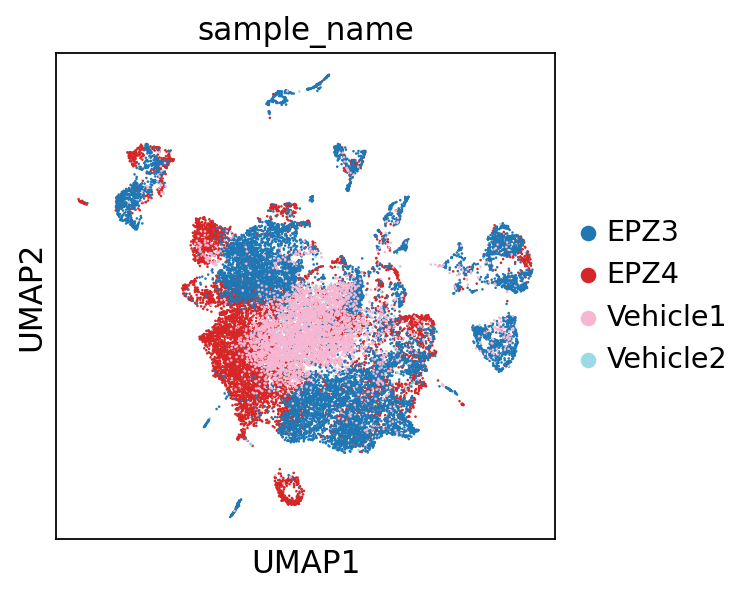

In [37]:
sc.pl.umap(adata,color='sample_name')

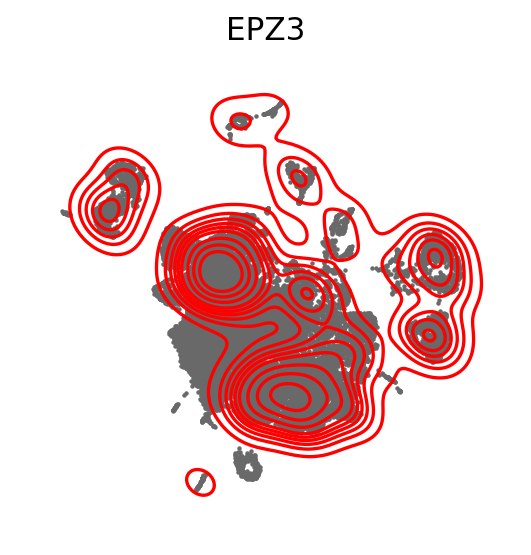

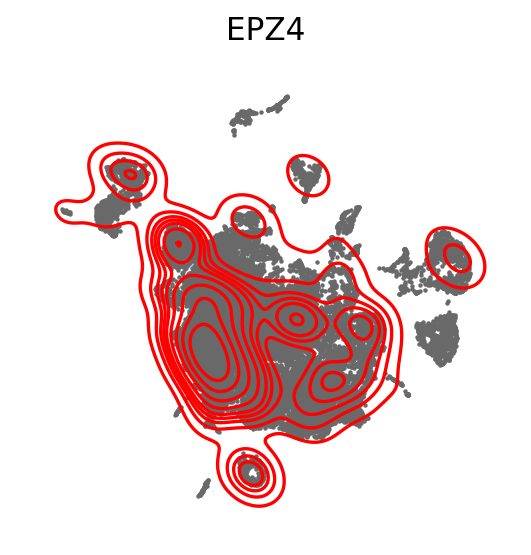

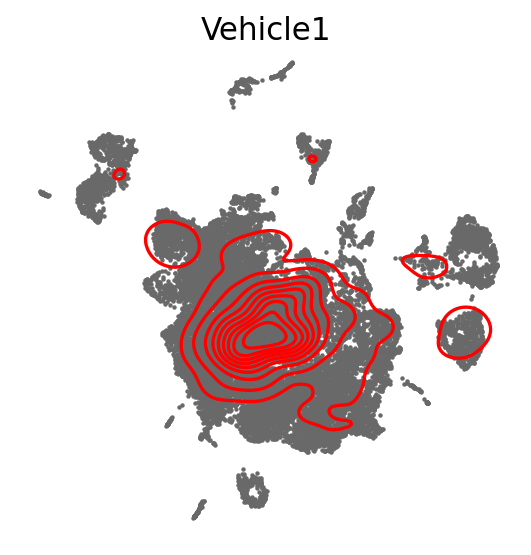

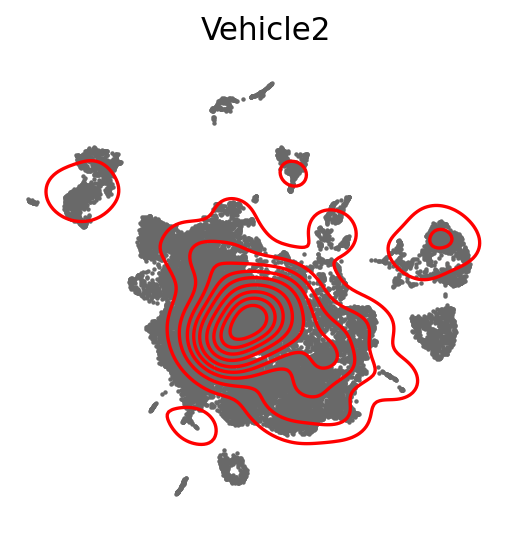

In [39]:
for sample in np.unique(adata_complete.obs.sample_name):
    meta = adata_complete.obsm['X_umap']
    sub_ad = adata_complete[adata_complete.obs['sample_name']==sample].copy()
    #sub_meta = sub_ad.obs.copy()
    plt.figure()
    plt.scatter(meta.T[0],meta.T[1],s=1,c='dimgrey')
    sns.kdeplot(x=sub_ad.obsm['X_umap'].T[0],y=sub_ad.obsm['X_umap'].T[1],color='r')
    plt.title(sample)
    plt.grid(False)
    plt.axis('off')
    plt.show()

In [40]:
np.unique(adata_complete.obs['treatment_stat'])

array(['EPZ', 'Vehicle'], dtype=object)

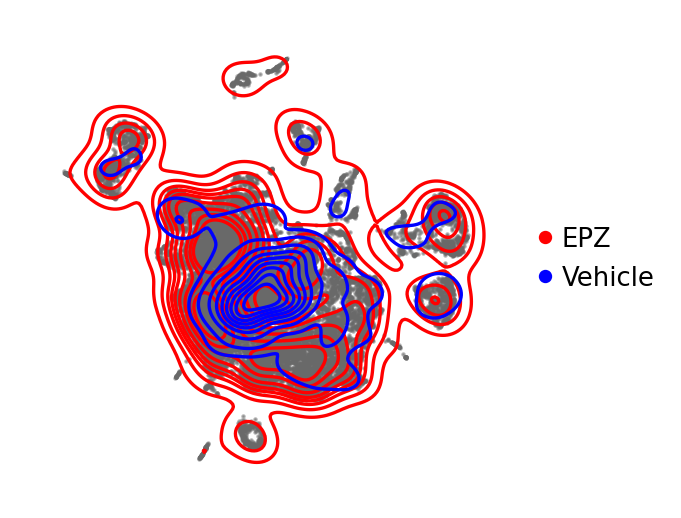

In [45]:
meta = adata_complete.obsm['X_umap']
veh_ad = adata_complete[adata_complete.obs['treatment_stat']=='Vehicle'].copy()
epz_ad = adata_complete[adata_complete.obs['treatment_stat']=='EPZ'].copy()
plt.figure()
plt.scatter(meta.T[0],meta.T[1],s=1,c='dimgrey',alpha=.5)
sns.kdeplot(x=epz_ad.obsm['X_umap'].T[0],y=epz_ad.obsm['X_umap'].T[1],color='r')
sns.kdeplot(x=veh_ad.obsm['X_umap'].T[0],y=veh_ad.obsm['X_umap'].T[1],color='b')
plt.grid(False)
plt.axis('off')
colors=['r','b']
texts=['EPZ','Vehicle']
patches = [ plt.plot([],[], marker="o", ms=5, ls="", linewidth=0.6,color=colors[i], 
                label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(1, 0.5), 
        loc='center left', ncol=1,fontsize='small',edgecolor='white')
plt.show()

In [46]:
stacked_bar_info = adata.obs[['sample_name','leiden_scvi']].copy()
stacked_bar_info['leiden_scvi'] = [str(x) for x in stacked_bar_info['leiden_scvi']]
stacked_bar_info = stacked_bar_info.groupby(['leiden_scvi','sample_name']).size()

stacked_bar_info = pd.DataFrame(stacked_bar_info)
stacked_bar_info = stacked_bar_info.reset_index()
stacked_bar_info = stacked_bar_info.rename(columns={0:'count'})

stacked_bar_info['pct'] = stacked_bar_info['count'] / stacked_bar_info.groupby('leiden_scvi')['count'].transform('sum')
stacked_bar_info = stacked_bar_info.drop(columns={'count'})
stacked_bar_info = stacked_bar_info.pivot(index='leiden_scvi', columns='sample_name', values='pct')
stacked_bar_info = stacked_bar_info.reset_index()

stacked_bar_info['leiden_scvi'] = [int(x) for x in stacked_bar_info['leiden_scvi']]
stacked_bar_info = stacked_bar_info.sort_values(by='leiden_scvi')

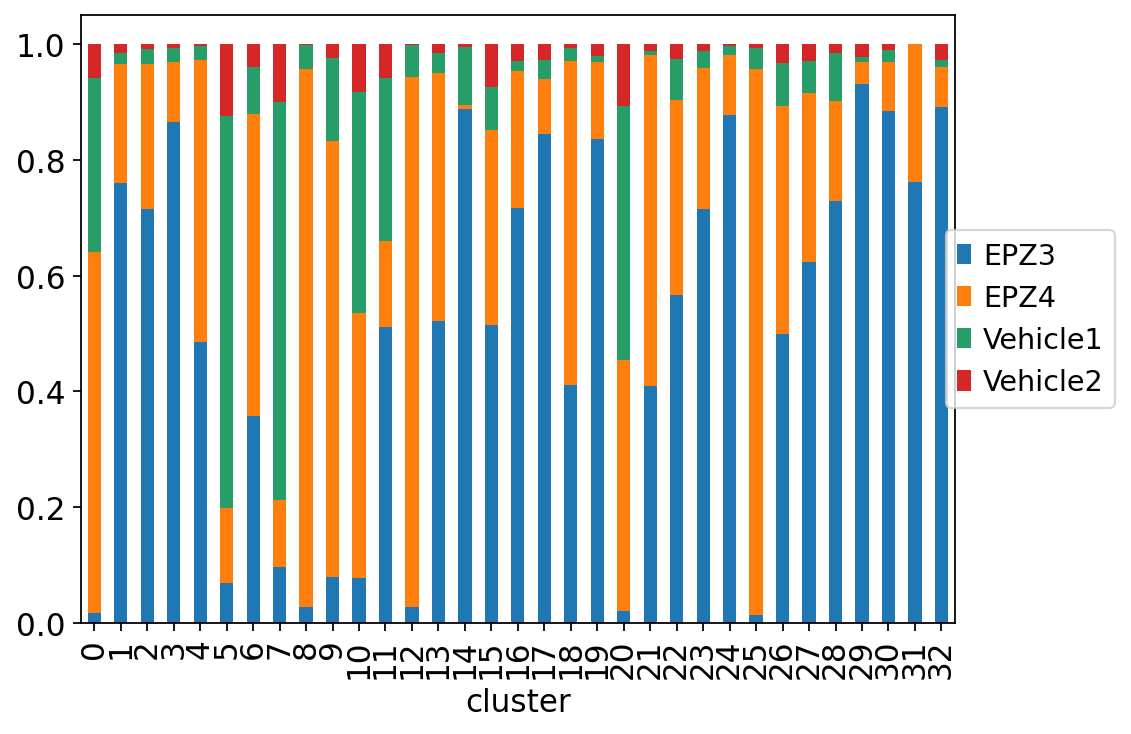

In [47]:
ax = stacked_bar_info.plot(x='leiden_scvi', kind='bar', stacked=True,figsize=(7,5))
ax.grid(False)
plt.legend(loc='center right',bbox_to_anchor=(1.2,.5))
plt.xlabel('cluster')

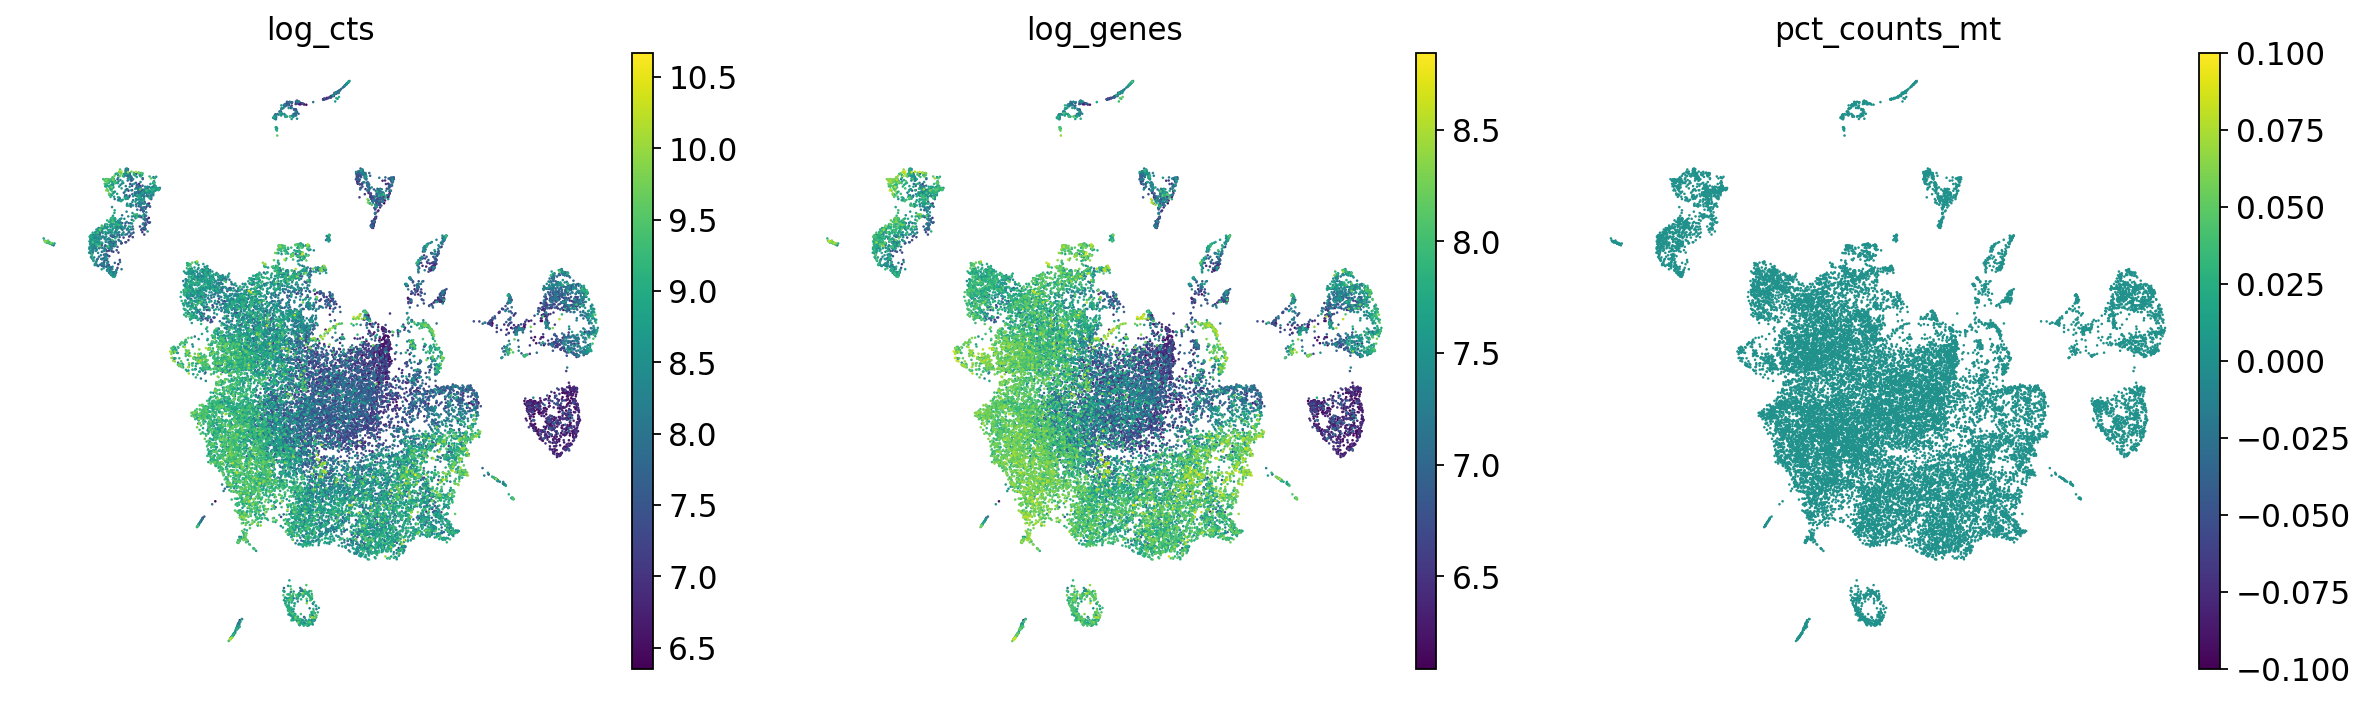

In [58]:
sc.pl.umap(adata_complete, color=['log_cts', 'log_genes','pct_counts_mt'],frameon=False)

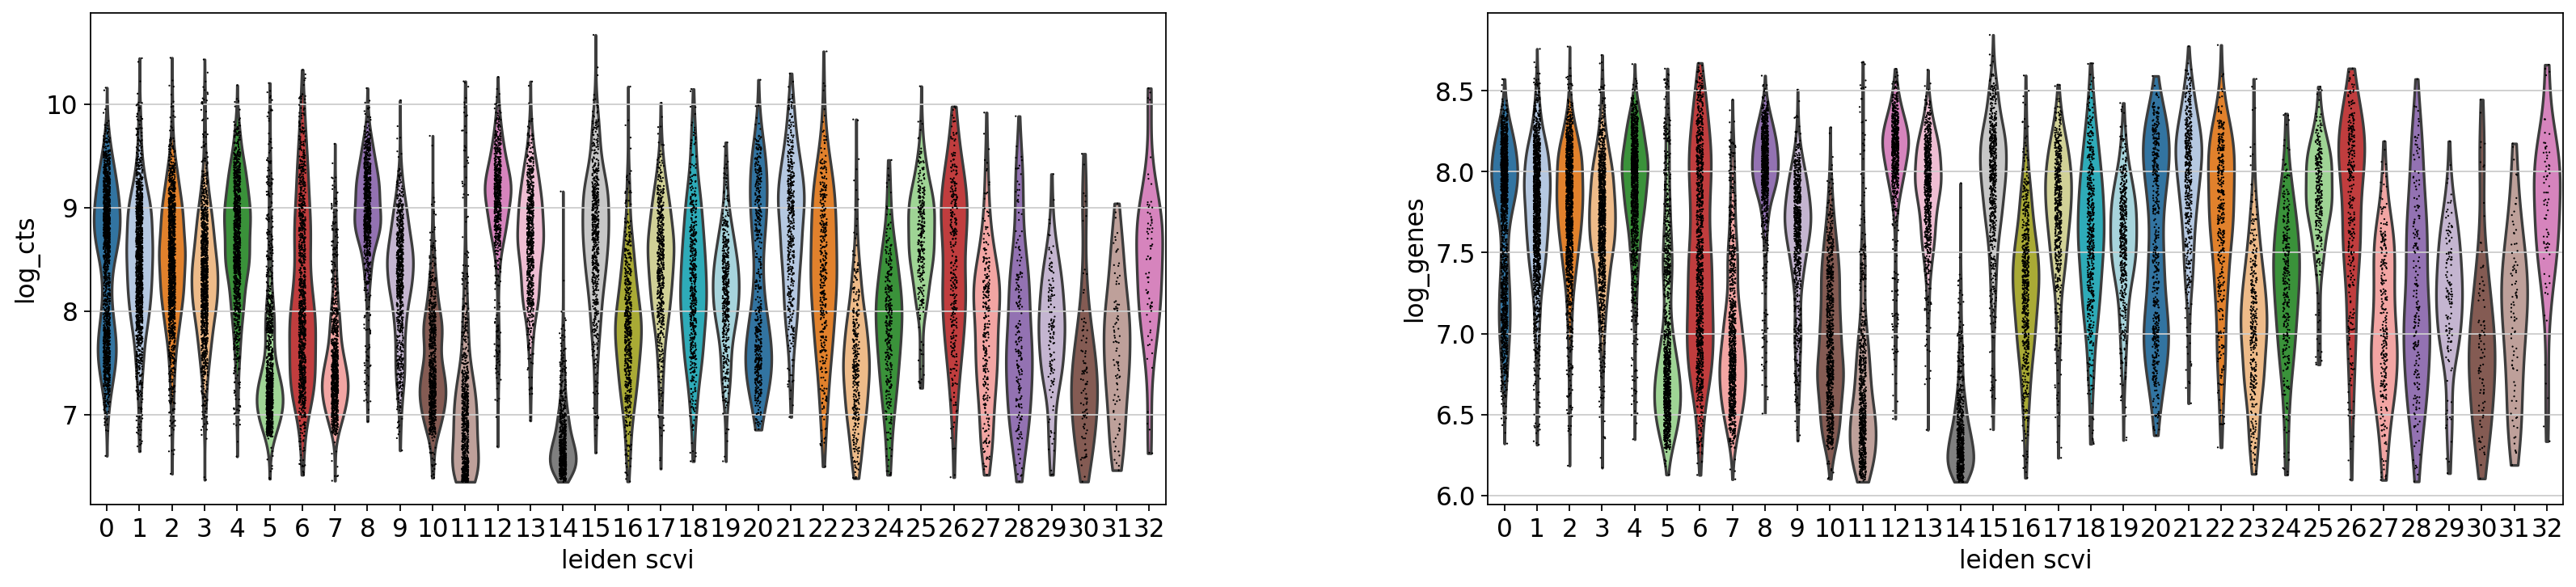

In [49]:
sc.settings.set_figure_params(figsize=(9,5))
sc.pl.violin(adata_complete, ['log_cts', 'log_genes'], groupby='leiden_scvi',palette='tab20')

In [51]:
remove = ['Cd24', 'Cd26', 'Vegfr2']
for key in mouse_features_d.keys():
    mouse_features_d[key] = [x for x in mouse_features_d[key] if x not in remove]

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:16)
Storing dendrogram info using `.uns['dendrogram_leiden_scvi']`
categories: 0, 1, 2, etc.
var_group_labels: Immune, Fibroblast, Endothelial, etc.


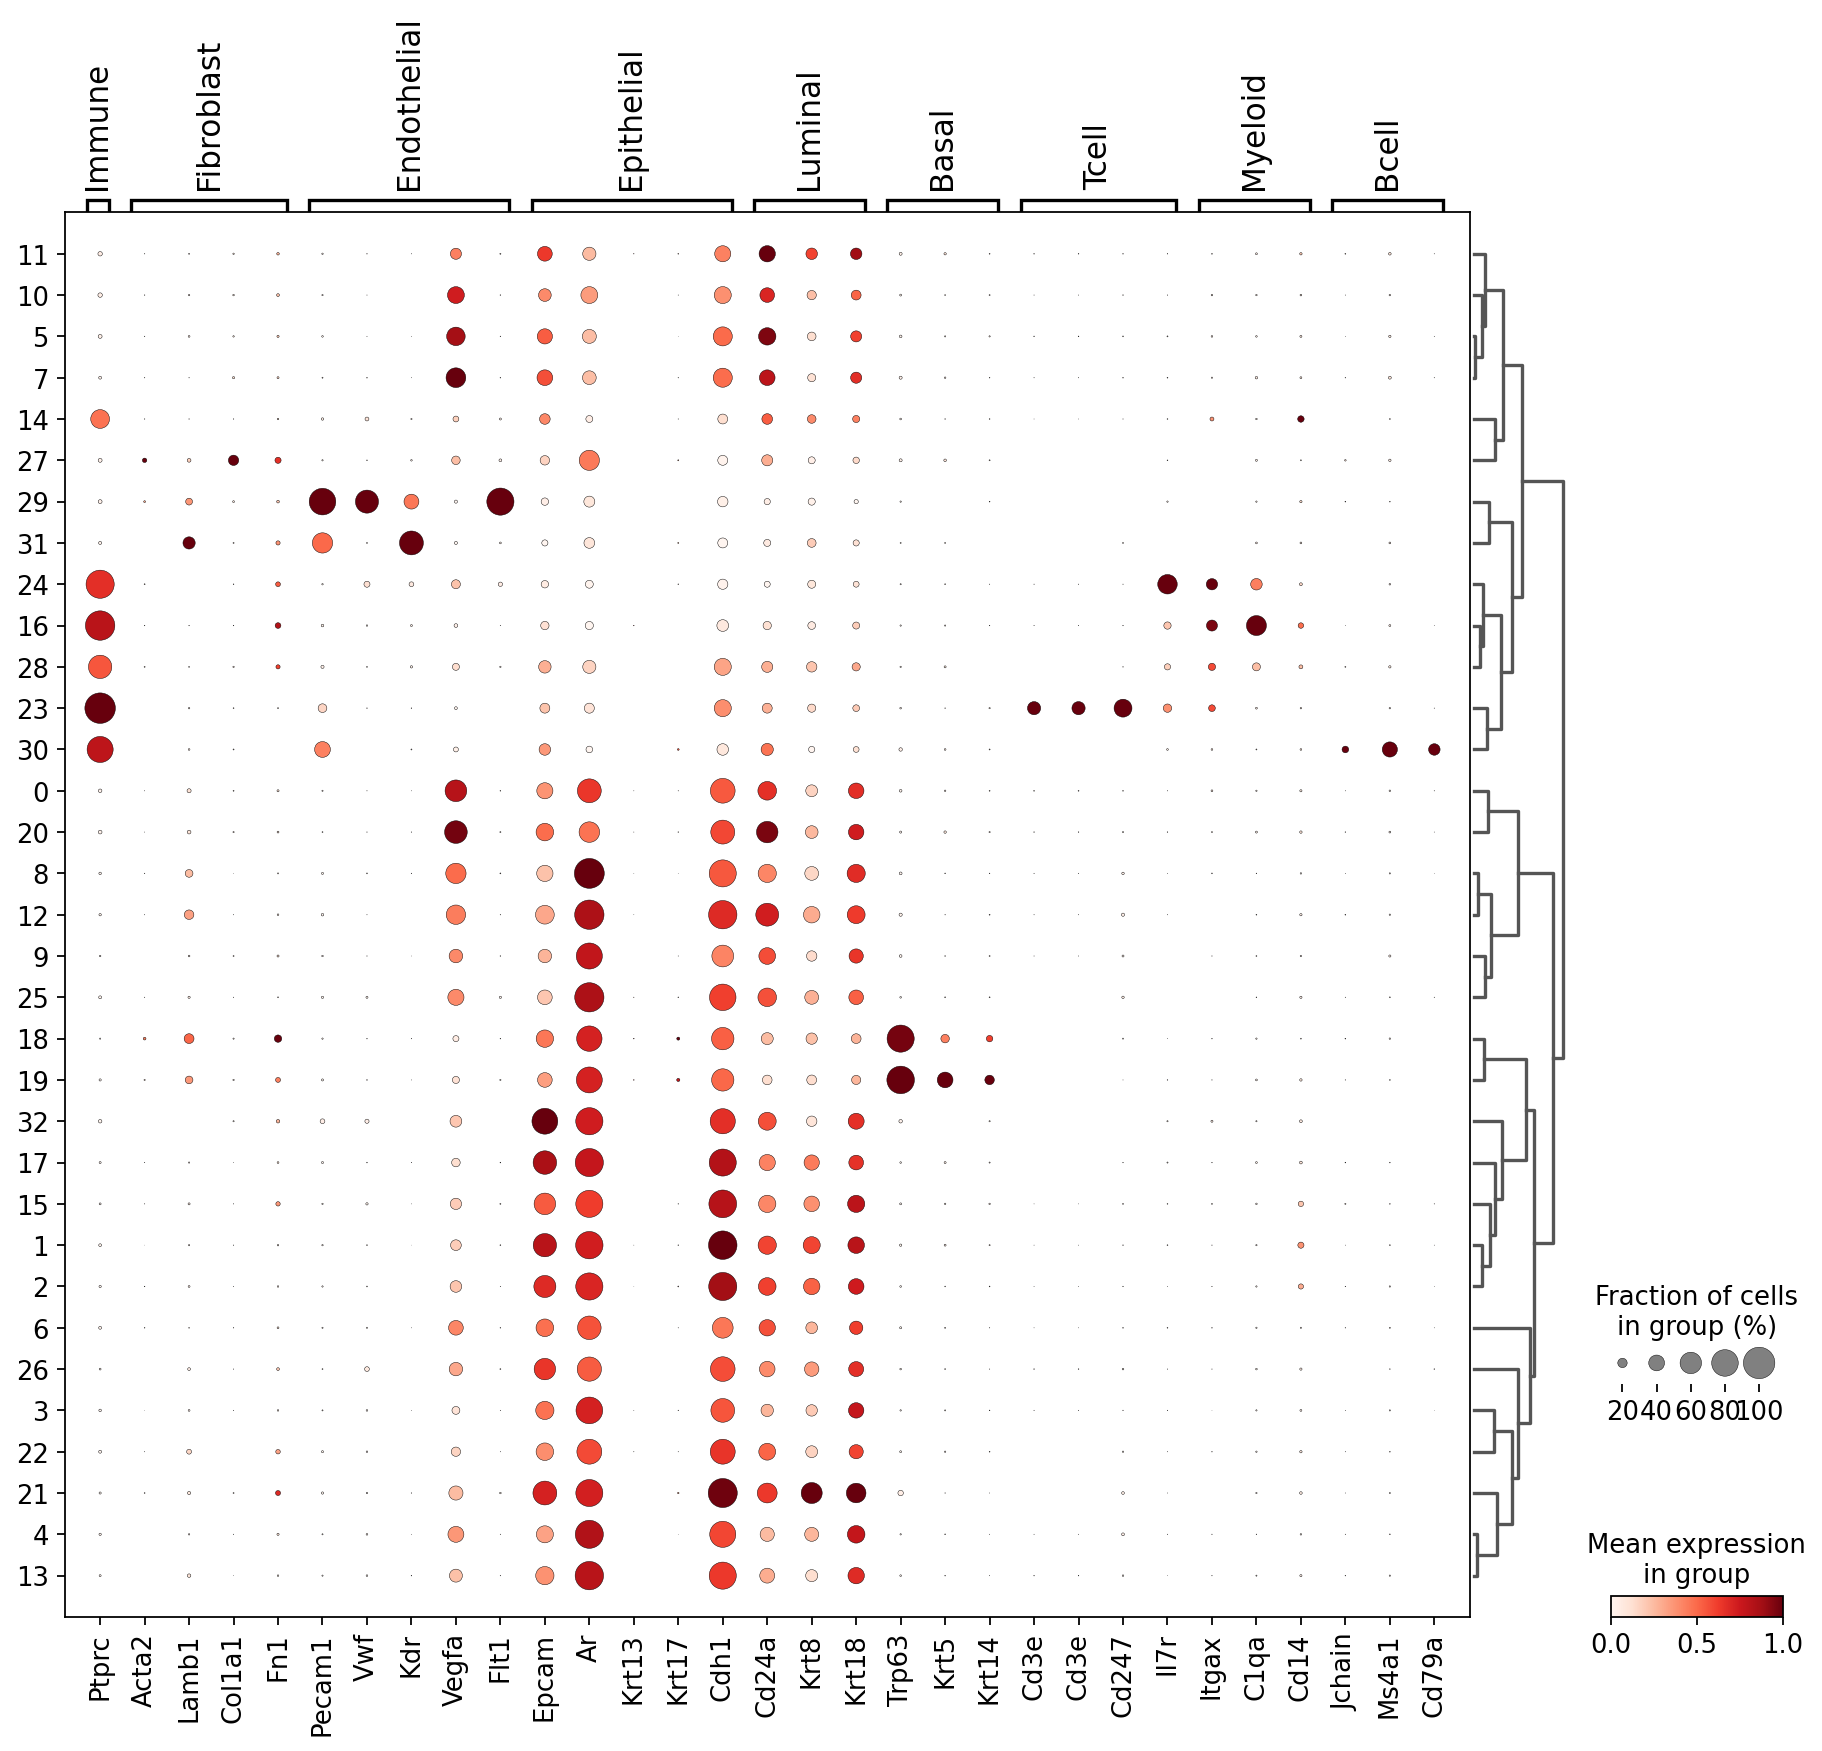

In [52]:
ax = sc.pl.dotplot(adata_complete, mouse_features_d, groupby='leiden_scvi', standard_scale='var',dendrogram=True)

In [53]:
len(np.unique(adata.obs['leiden_scvi']))

33

In [54]:
celltype_to_clusters = {
    'Immune': ['14','24','16','28','23','30'],
    'Fibroblast': ['27'],
    'Endothelial': ['29'],
    'Fibroblast/Endothelial': ['31'],
    'Luminal': ['0','20','8','12','9','25','32','17','15','1','2','6','26','3','22','21','4','13','11','10','5','7'],
    'Basal': ['18','19']
}

In [55]:
adata_complete.obs['celltype'] = ['unsure']*adata_complete.n_obs
for celltype in celltype_to_clusters.keys():
    adata_complete.obs['celltype'] = np.where(adata_complete.obs['leiden_scvi'].isin(celltype_to_clusters[celltype]), celltype, adata_complete.obs['celltype'])

/home/tnoel/anaconda3/envs/myenv_39/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical


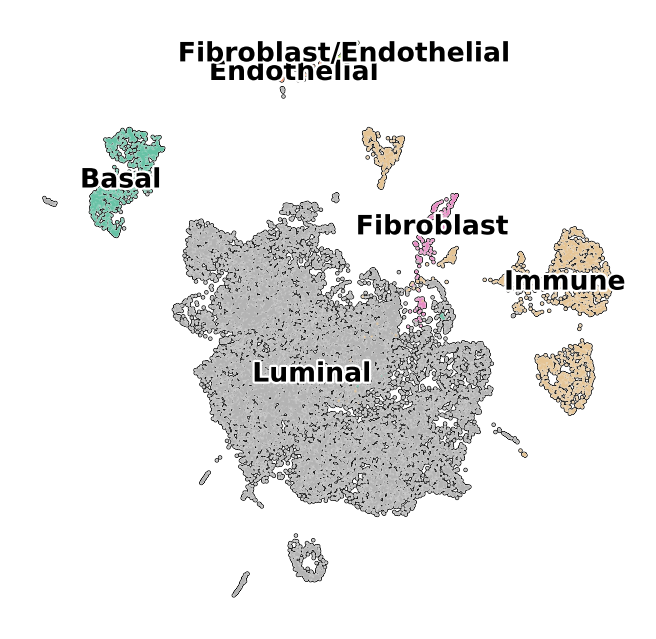

In [56]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata_complete, color='celltype', add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2,frameon=False, palette='Set2',title='')

computing score 'Immune_score'
    finished: added
    'Immune_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:01)


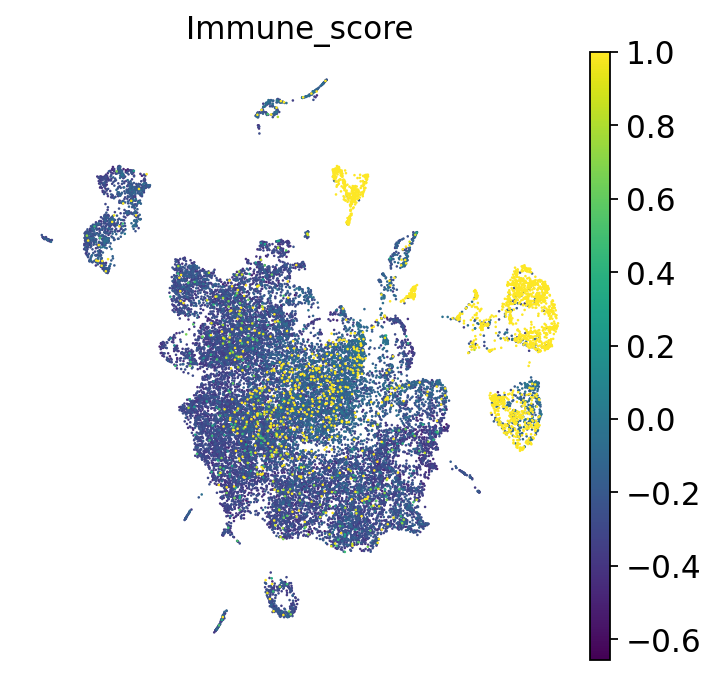

computing score 'Fibroblast_score'
    finished: added
    'Fibroblast_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:01)


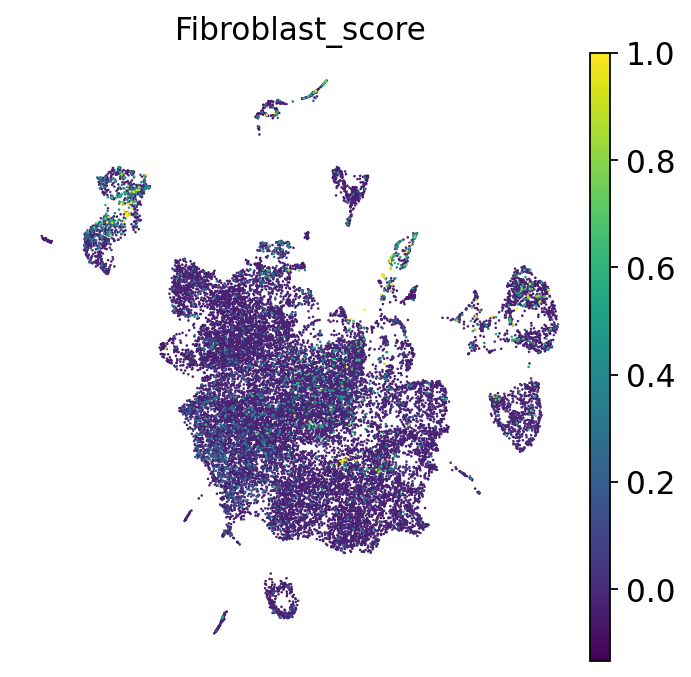

computing score 'Endothelial_score'
    finished: added
    'Endothelial_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:01)


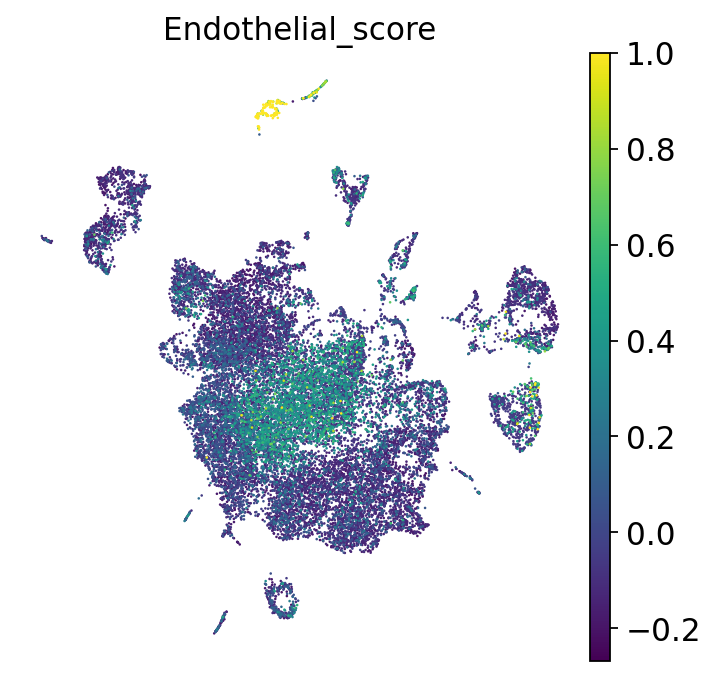

computing score 'Epithelial_score'
    finished: added
    'Epithelial_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:01)


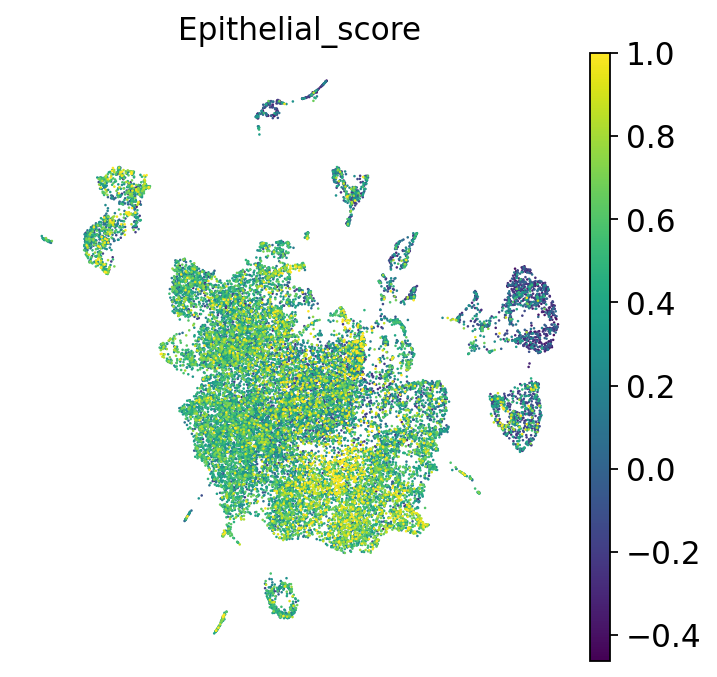

computing score 'Luminal_score'
    finished: added
    'Luminal_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:01)


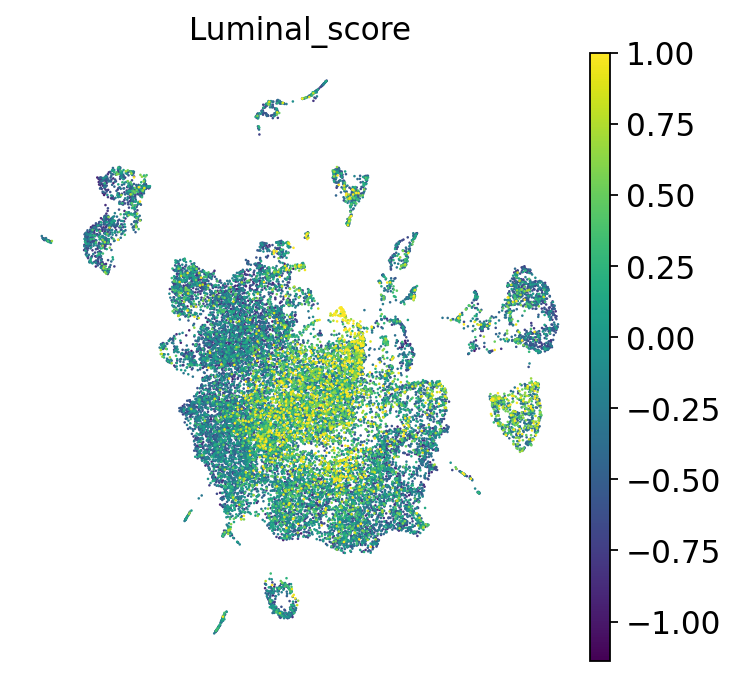

computing score 'Basal_score'
    finished: added
    'Basal_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:01)


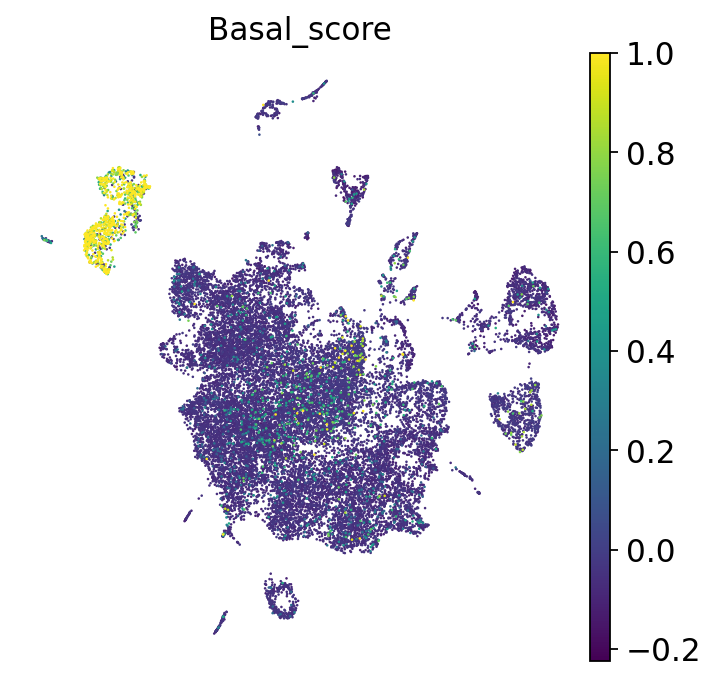

computing score 'Tcell_score'
    finished: added
    'Tcell_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:01)


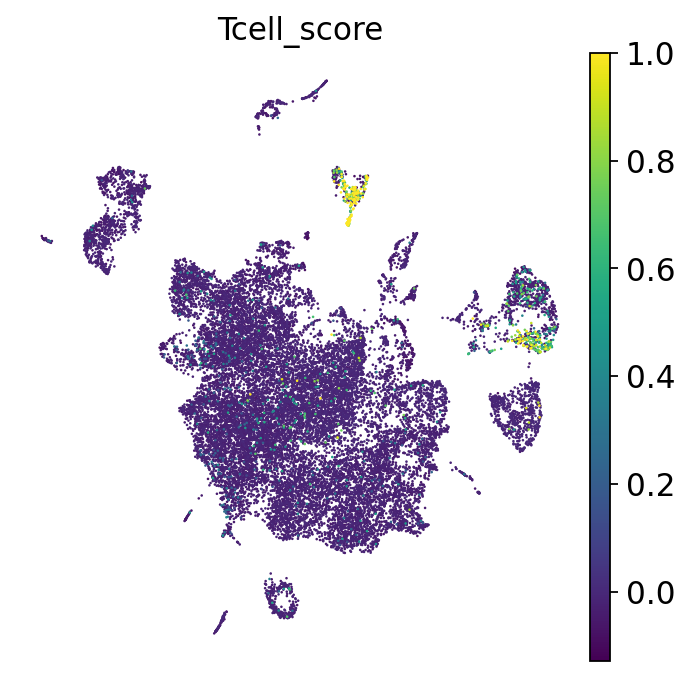

computing score 'Myeloid_score'
    finished: added
    'Myeloid_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:01)


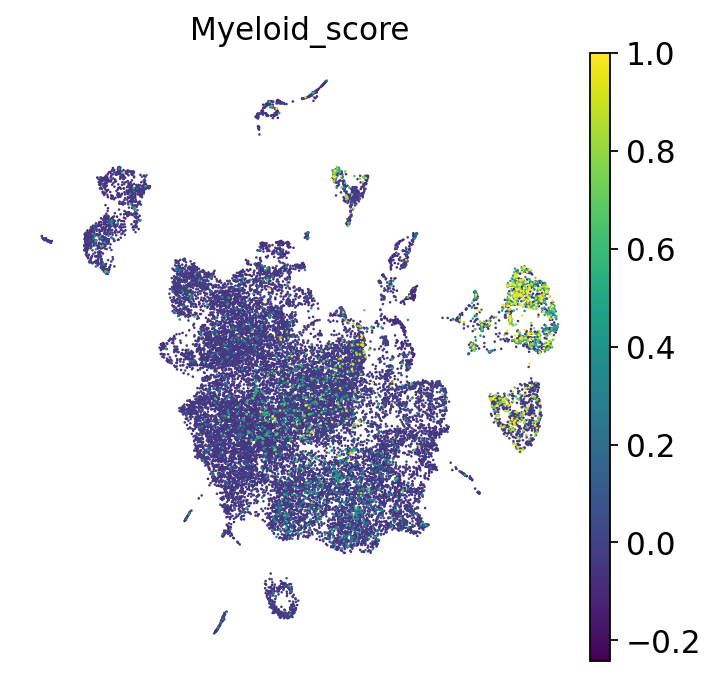

computing score 'Bcell_score'
    finished: added
    'Bcell_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:01)


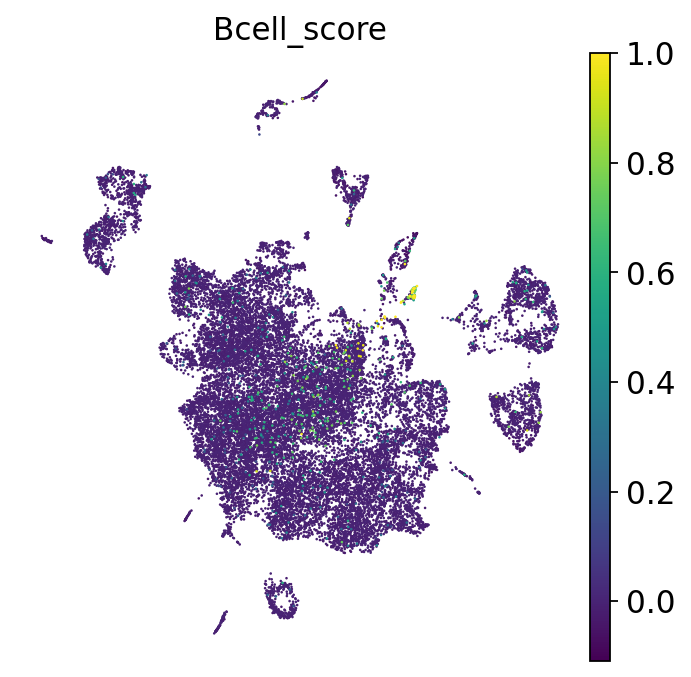

In [59]:
for key in mouse_features_d.keys():
    gene_list = mouse_features_d[key]
    sc.tl.score_genes(adata_complete, gene_list,score_name='{}_score'.format(key))
    sc.settings.set_figure_params(figsize=(5,5))
    sc.pl.umap(adata_complete, color='{}_score'.format(key),vmax=1,frameon=False)